In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Time Series Forecasting with ARIMA

In [4]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2023-05-02  107.660004  107.730003  104.500000  105.980003  105.980003   
247 2023-05-03  106.220001  108.129997  105.620003  106.120003  106.120003   
248 2023-05-04  106.160004  106.300003  104.699997  105.209999  105.209999   
249 2023-05-05  105.320000  106.440002  104.738998  106.214996  106.214996   
250 2023-05-08  105.794998  108.419998  105.790001  108.239998  108.239998   

       Volume  
246  20343100  
247  17116300  
248  19780600  
249  20705300  
250  17244900  


We only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [5]:
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2022-05-09  113.084000
1 2022-05-10  114.584503
2 2022-05-11  113.960999
3 2022-05-12  113.161003
4 2022-05-13  116.515503


Now let’s visualize the close prices of Google before moving forward:

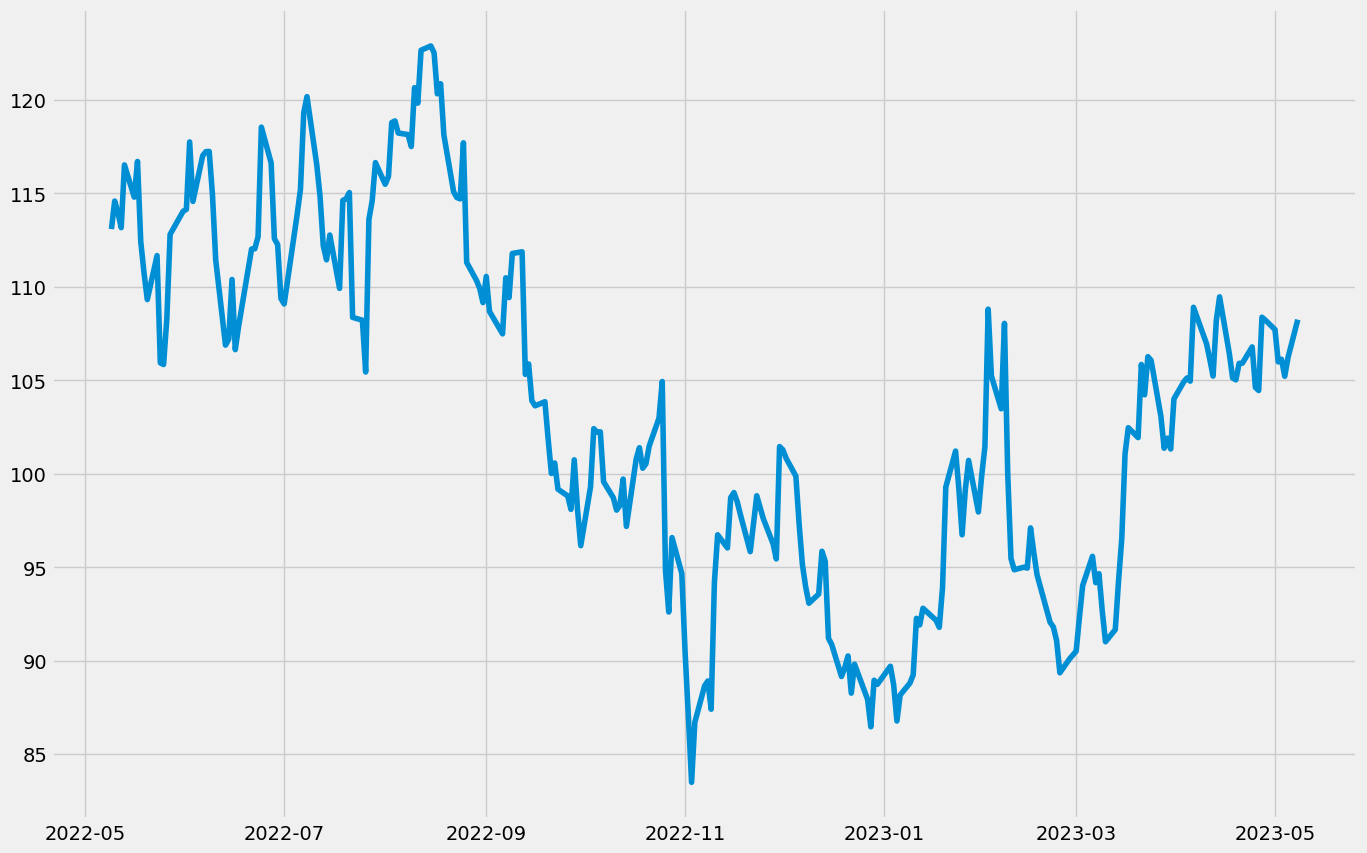

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

# Using ARIMA for Time Series Forecasting

Before using the ARIMA model, we have to figure out whether our data is stationary or seasonal. The data visualization graph about the closing stock prices above shows that our dataset is not stationary. To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

In [14]:
from plotly.tools import mpl_to_plotly
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], 
                            model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig = mpl_to_plotly(fig)
fig.show()

<Figure size 640x480 with 0 Axes>

So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. It will help you learn using both models.

To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

Now here’s how to find the value of p:

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

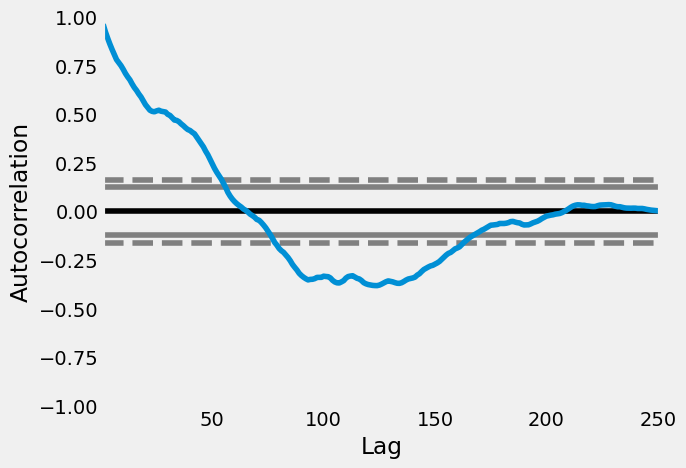

In [15]:
pd.plotting.autocorrelation_plot(data["Close"])

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



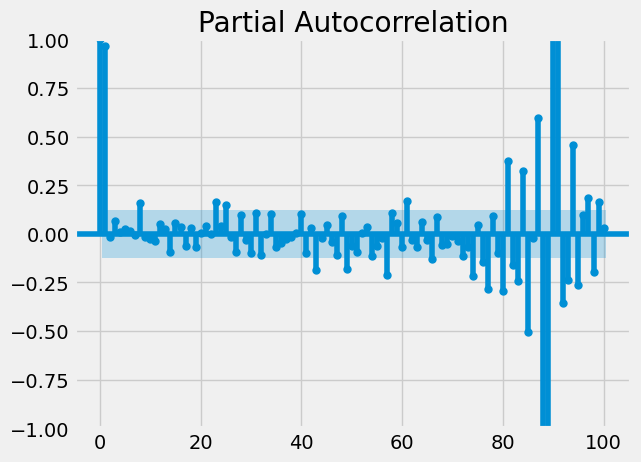

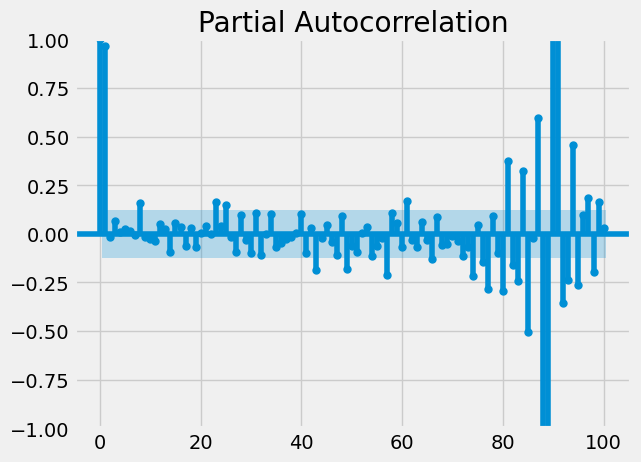

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2. Now let’s build an ARIMA model:

In [19]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -582.131
Date:                Tue, 09 May 2023   AIC                           1180.261
Time:                        19:12:38   BIC                           1208.433
Sample:                             0   HQIC                          1191.600
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0323      0.691      0.047      0.963      -1.323       1.387
ar.L2          0.7018      0.674      1.042      0.297      -0.618       2.022
ar.L3         -0.0176      0.093     -0.189      0.8

In [ ]:
# p, d, q = 5, 1, 2
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = SARIMAX(data["Close"], order=(p,d,q))  
# fitted = model.fit(disp=-1)  
# print(fitted.summary())


Here’s how to predict the values using the ARIMA model:

In [20]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1      113.083993
2      114.570872
3      113.851287
4      113.179650
          ...    
246    107.600845
247    105.876047
248    106.067820
249    105.154068
250    106.193724
Name: predicted_mean, Length: 251, dtype: float64


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [21]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39083D+00    |proj g|=  1.04915D-01


 This problem is unconstrained.



At iterate    5    f=  2.30837D+00    |proj g|=  3.50005D-02

At iterate   10    f=  2.28872D+00    |proj g|=  1.88179D-02

At iterate   15    f=  2.28583D+00    |proj g|=  2.41032D-03

At iterate   20    f=  2.28529D+00    |proj g|=  4.31247D-03

At iterate   25    f=  2.28445D+00    |proj g|=  3.86610D-03

At iterate   30    f=  2.28436D+00    |proj g|=  6.12079D-04

At iterate   35    f=  2.28433D+00    |proj g|=  3.82109D-03

At iterate   40    f=  2.28420D+00    |proj g|=  7.78167D-04

At iterate   45    f=  2.28417D+00    |proj g|=  7.46090D-04


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  2.28410D+00    |proj g|=  1.07085D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     54      1     0     0   1.071D-03   2.284D+00
  F =   2.2841016481986389     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -573.310
Date:                            Tue, 09 May 2023   AIC                           1176.6

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:

In [22]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

251    107.730793
252    108.486913
253    109.427717
254    108.772431
255    108.660469
256    108.345076
257    108.802320
258    108.375006
259    108.538414
260    109.866737
261    109.244668
Name: predicted_mean, dtype: float64


Here’s how you can plot the predictions:

<AxesSubplot: >

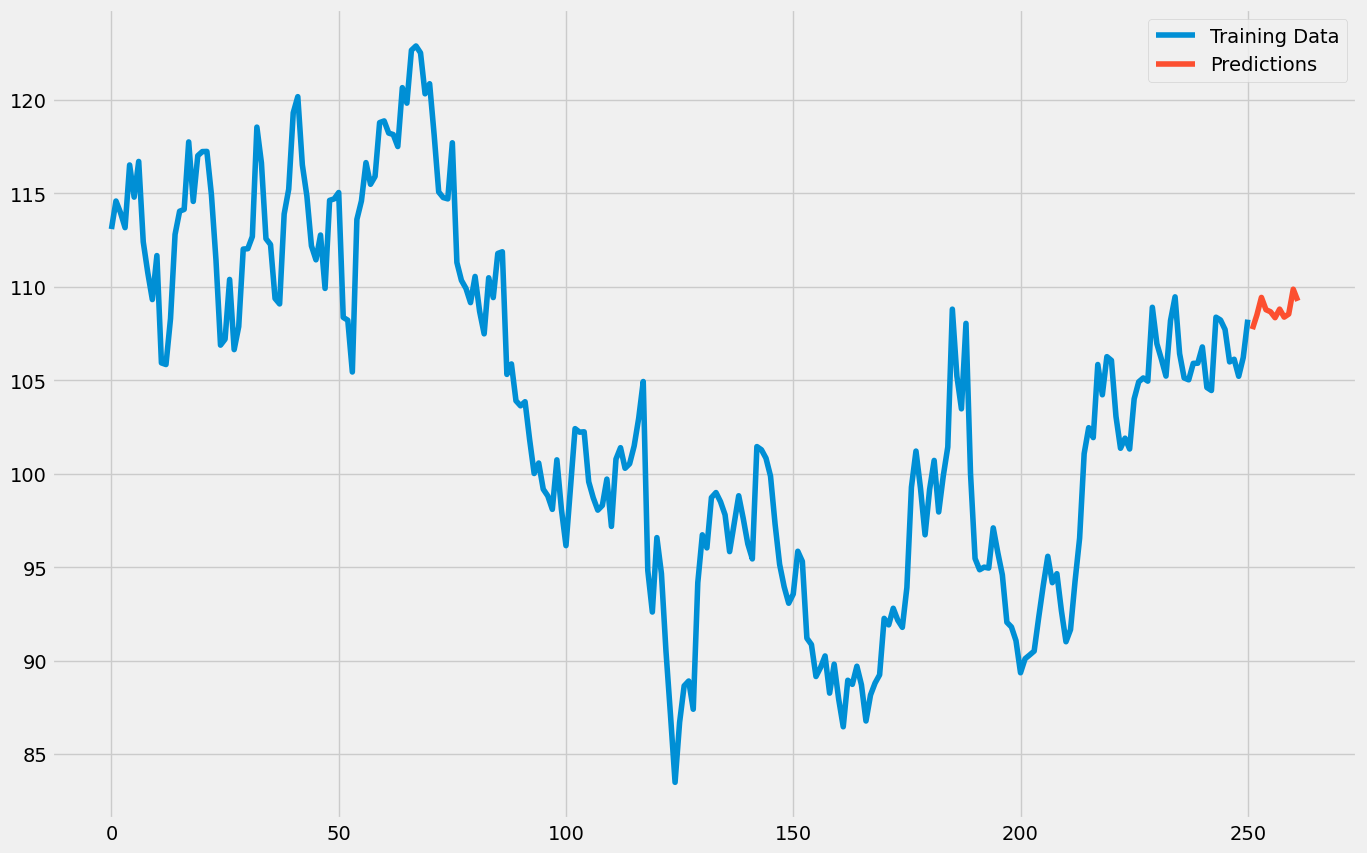

In [24]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

So this is how you can use ARIMA or SARIMA models for Time Series Forecasting using Python.

ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. If the data is stationary, we need to use ARIMA, if the data is seasonal, we need to use Seasonal ARIMA (SARIMA).